In [71]:
import numpy as np
import torch
import torch.nn
import torch.optim
from abc import abstractmethod
from collections import defaultdict
from functools import lru_cache
from itertools import count
from typing import List, Dict
from typing import Tuple, Any
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from torch.nn import MSELoss, ReLU, L1Loss
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [72]:
from importlib import reload
from config import Config
import config
from data import MDataset, Graph, load_graphs, save_dataset_pkl, load_dataset_pkl, save_scalers_pkl, load_scalers_pkl
import data
from base_module import MModule, nested_detach
import base_module
from executor import single_train_loop, grid_search_loop
import executor
from objects import ModelType
import objects
from metric import MetricUtil
import metric
from logger import init_logging
import logger
reload(config)
reload(data)
reload(base_module)
reload(executor)
reload(objects)
reload(metric)
reload(logger)
from config import Config
from data import MDataset, Graph, load_graphs
from base_module import MModule
from objects import ModelType
from metric import MetricUtil
from logger import init_logging
init_logging()

datasets_path: /root/guohao/repos/DLT-perf-model/datasets
configs_path: /root/guohao/repos/DLT-perf-model/notebooks/configs


In [75]:
dataset_environment_str = "T4_CPUALL"
normalizer_cls = StandardScaler # MinMaxScaler
dummy = False

In [74]:
train_configs = {
    ModelType.MLP.name: Config.from_dict({
        "model": "MLP",
        "all_seed": 42,
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": False,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 5,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    }),
    ModelType.PerfNet.name: Config.from_dict({
        "model": "PerfNet",
        "dataset_environment_str": dataset_environment_str,
        "dataset_normalization": "Standard",
        "all_seed": 42,
        "dataset_params": {
            "duration_summed": False,
        },
        "dataset_dummy": True,
        "batch_size": 32,
        "eval_steps": 5000,
        "learning_rate": 1e-5,
        "epochs": 10,
        "optimizer": "Adam",
        "meta_configs": {
            "learning_rate": 0.005,
            "meta_learning_rate": 0.001,
            "meta_train_steps": 1000,
            "meta_task_per_step": 8,
            "meta_fast_adaption_step": 5,
            "meta_dataset_train_environment_strs": [dataset_environment_str],
            "meta_dataset_eval_environment_strs": [dataset_environment_str],
        },
    })
}

model_type = ModelType.MLP
conf = train_configs[model_type.name]

ValueError: invalid literal for int() with base 10: 'ALL'

In [ ]:
eval_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=200_000)
train_graphs = load_graphs(dataset_environment_str,
                            train_or_eval="train",
                            use_dummy=dummy,
                            max_row=1_000_000)

[2023-12-12 16:33:12,512] {data.py:441} INFO - Loading graphs train
[2023-12-12 16:33:12,513] {data.py:412} INFO - Loading merged.csv
[2023-12-12 16:33:12,981] {data.py:415} INFO - Loaded merged.csv, 200000 rows
[2023-12-12 16:33:13,359] {data.py:421} INFO - Loaded mnasnet1_3.180_7.csv, 769 rows
[2023-12-12 16:33:14,095] {data.py:421} INFO - Loaded convnext_small.96_7.csv, 1595 rows
[2023-12-12 16:33:14,524] {data.py:421} INFO - Loaded googlenet.120_7.csv, 905 rows
[2023-12-12 16:33:14,869] {data.py:421} INFO - Loaded mobilenet_v3_small.249_7.csv, 732 rows
[2023-12-12 16:33:15,007] {data.py:421} INFO - Loaded squeezenet1_0.173_7.csv, 280 rows
[2023-12-12 16:33:15,359] {data.py:421} INFO - Loaded rand_4000.251_7.csv, 719 rows
[2023-12-12 16:33:16,529] {data.py:421} INFO - Loaded densenet161.132_7.csv, 2507 rows
[2023-12-12 16:33:17,768] {data.py:421} INFO - Loaded densenet169.127_7.csv, 2633 rows
[2023-12-12 16:33:17,933] {data.py:421} INFO - Loaded vgg19_bn.119_7.csv, 333 rows
[2023-12

In [ ]:
len(eval_graphs), len(train_graphs)

(162, 819)

In [ ]:

def init_dataset(graphs: List[Graph]) -> MDataset:
    op_X, op_Y = list(), list()
    data_idx_to_graph = dict()
    counter = iter(count())
    op_feature_len = 0

    def node_features(g: Graph) -> Tuple[
        List[Dict], List[Dict]]:
        X, Y = list(), list()
        for i, node in enumerate(g.nodes):
            x_op_feature = node.op.to_feature_array("complex")
            x = {
                "x_op_feature": x_op_feature
            }
            node_durations = (node.duration,node.gap)
            x["x_id"] = i
            x["x_graph_id"] = g.ID
            y = {"y_node_durations": node_durations, "y_id": i, "y_graph_id": g.ID}
            X.append(x)
            Y.append(y)
        return X, Y

    for graph in graphs:
        X, Y = node_features(graph)
        for x in X:
            # if len(x['x_op_feature'])!=37:
            #     print(x['x_graph_id'], len(x['x_op_feature']))
            op_feature_len = max(op_feature_len, len(x["x_op_feature"]))
        op_X.extend(X)
        op_Y.extend(Y)
        for i in range(len(X)):
            data_idx_to_graph[next(counter)] = graph
    for x in op_X:
        v = x["x_op_feature"]
        x["x_op_feature"] = np.pad(v, (0, op_feature_len - v.size))

    dataset = MDataset(op_X, op_Y)
    return dataset

train_ds = init_dataset(train_graphs)
eval_ds = init_dataset(eval_graphs)

In [ ]:
def get_scalers(ds):
    scaler_cls = normalizer_cls
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array)
    y_array = np.array(y_array)

    op_feature_scaler = scaler_cls()
    op_feature_scaler.fit(op_feature_array)

    y_scaler = scaler_cls()
    y_scaler.fit(y_array)
    return op_feature_scaler, y_scaler

scalers = get_scalers(train_ds)
op_feature_scaler, y_scaler = scalers

In [ ]:

def preprocess_dataset(ds: MDataset) -> MDataset:
    op_feature_array = list()
    y_array = list()

    for data in ds:
        feature, label = data
        op_feature_array.append(feature["x_op_feature"])
        y_array.append(label["y_node_durations"])

    op_feature_array = np.array(op_feature_array, dtype=np.float32)
    y_array = np.array(y_array, dtype=np.float32)


    op_feature_array = op_feature_scaler.transform(op_feature_array)
    y_array = y_scaler.transform(y_array)

    processed_features = list()
    processed_labels = list()
    for i, data in enumerate(ds):
        feature, label = data
        processed_features.append({
            "x_id": feature["x_id"],
            "x_graph_id": feature["x_graph_id"],
            # 运行时再传到cuda那边
            # "x_op_feature": torch.Tensor(op_feature_array[i]).to(device=self.conf.device)
            "x_op_feature": torch.Tensor(op_feature_array[i])
        })
        processed_labels.append({
            "y_id": label["y_id"],
            "y_graph_id": label["y_graph_id"],
            # "y_node_durations": torch.Tensor(y_array[i]).to(device=self.conf.device)
            "y_node_durations": torch.Tensor(y_array[i])
        })

    ds = MDataset(processed_features, processed_labels)
    return ds

preprocessed_train_ds = preprocess_dataset(train_ds)
preprocessed_eval_ds = preprocess_dataset(eval_ds)

In [ ]:
save_dataset_pkl(preprocessed_train_ds, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)
save_dataset_pkl(preprocessed_eval_ds, conf.dataset_environment, "OpBased", 'eval',
                         conf.dataset_normalization)
save_scalers_pkl(scalers, conf.dataset_environment, "OpBased", 'train',
                         conf.dataset_normalization)

In [ ]:
preprocessed_train_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'train', 
                                         conf.dataset_normalization)
preprocessed_eval_ds = load_dataset_pkl(conf.dataset_environment, "OpBased", 'eval',
                                        conf.dataset_normalization)
scalers = load_scalers_pkl(conf.dataset_environment, "OpBased", 'train',
                           conf.dataset_normalization)


Loading dataset T4_CPU100 OpBased train Standard
Loading dataset T4_CPU100 OpBased eval Standard
Loading scalers T4_CPU100 OpBased train, Standard


In [ ]:
op_feature_scaler, y_scaler = scalers

In [ ]:
def compute_evaluate_metrics(input_batches, output_batches, eval_loss) -> Dict[str, float]:
    batches_len = len(input_batches)

    def compute_op_durations(_logits):
        transformed: np.ndarray = y_scaler.inverse_transform(_logits)
        durations = transformed.sum(axis=1)
        return durations

    graph_id_to_duration_pred = defaultdict(int)
    for idx in range(batches_len):
        inputs = input_batches[idx]
        logits = output_batches[idx]
        logits = nested_detach(logits)
        logits = logits.cpu().numpy()
        graph_ids = inputs["x_graph_id"]
        op_durations = compute_op_durations(logits)
        for i, graph_id in enumerate(graph_ids):
            op_duration = op_durations[i].item()
            graph_id_to_duration_pred[graph_id] += op_duration
    duration_metrics = MetricUtil.compute_duration_metrics(eval_graphs, graph_id_to_duration_pred)
    return {"eval_loss": eval_loss, **duration_metrics}


In [ ]:

def to_device(conf, features, labels):
    features['x_op_feature'] = features["x_op_feature"].to(device=conf.device)
    labels['y_node_durations'] = labels['y_node_durations'].to(device=conf.device)
    return features, labels

In [ ]:
class MLPModel(MModule):

    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }

    def __init__(self, input_dimension, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.input = torch.nn.Linear(input_dimension, 256)
        self.relu1 = ReLU()
        self.dense1 = torch.nn.Linear(256, 128)
        self.relu2 = ReLU()
        self.dense2 = torch.nn.Linear(128, 64)
        self.relu3 = ReLU()
        self.output = torch.nn.Linear(64, output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = self.input(X)
        X = self.relu1(X)
        X = self.dense1(X)
        X = self.relu2(X)
        X = self.dense2(X)
        X = self.relu3(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_MLP_model() -> MModule | Any:
    sample_preprocessed_ds = preprocessed_train_ds
    sample_x_dict = sample_preprocessed_ds.features[0]
    sample_y_dict = sample_preprocessed_ds.labels[0]
    return MLPModel(input_dimension=len(sample_x_dict["x_op_feature"]),
                    output_dimension=len(sample_y_dict["y_node_durations"]))

In [ ]:

class PerfNetModel(MModule):
    @staticmethod
    def dimension_len(t):
        return t[-1] - t[0]
    
    @staticmethod
    def grid_search_model_params() -> Dict[str, List[Any]]:
        return {
            "learning_rate": [1e-3, 1e-4, 1e-5],
            'batch_size': [16, 32, 64],
            'epochs': [5, 10, 20, 30],
            'optimizer': ['Adam', 'SGD'],
        }

    def __init__(self, output_dimension, **kwargs):
        super().__init__(**kwargs)
        self.conv1 = torch.nn.LazyConv1d(out_channels=32, kernel_size=3, bias=True, padding_mode='zeros')
        self.conv2 = torch.nn.LazyConv1d(out_channels=128, kernel_size=2, bias=True, padding_mode='zeros')
        self.flatten = torch.nn.Flatten()
        self.dense1 = torch.nn.LazyLinear(32)
        self.relu1 = ReLU()
        self.dense2 = torch.nn.LazyLinear(64)
        self.relu2 = ReLU()
        self.dense3 = torch.nn.LazyLinear(128)
        self.relu3 = ReLU()
        self.dense4 = torch.nn.LazyLinear(256)
        self.relu4 = ReLU()
        self.dropout = torch.nn.Dropout(p=0.3)
        self.output = torch.nn.LazyLinear(output_dimension)
        self.loss_fn = L1Loss()

    def forward(self, X):
        X = X["x_op_feature"]
        X = torch.unsqueeze(X, dim=1)
        X = self.conv1(X)
        X = self.conv2(X)
        X = self.flatten(X)
        X = self.dense1(X)
        X = self.relu1(X)
        X = self.dense2(X)
        X = self.relu2(X)
        X = self.dense3(X)
        X = self.relu3(X)
        X = self.dense4(X)
        X = self.relu4(X)
        X = self.dropout(X)
        Y = self.output(X)
        return Y

    def compute_loss(self, outputs, Y):
        node_durations = Y["y_node_durations"]
        loss = self.loss_fn(outputs, node_durations)
        return loss


def init_PerfNet_model() -> MModule | Any:
    sample_y_dict = preprocessed_train_ds.labels[0]
    return PerfNetModel(output_dimension=len(sample_y_dict["y_node_durations"]))



In [ ]:
init_model_funcs = {
    ModelType.MLP.name: init_MLP_model,
    ModelType.PerfNet.name: init_PerfNet_model,
}


init_model = init_model_funcs[model_type.name]

model = init_model()
model = model.to(conf.device)


/root/anaconda3/envs/DLT-pref-model/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


[2023-12-12 16:50:25,793] {executor.py:120} INFO - ModelType.PerfNet start single training.
[2023-12-12 16:50:25,794] {executor.py:122} INFO - ModelType.PerfNet training epoch 0


  0%|          | 0/31250 [00:00<?, ?it/s]

[2023-12-12 16:50:25,868] {executor.py:139} INFO - ModelType.PerfNet trained for 0.075893648 seconds.
[2023-12-12 16:50:25,869] {executor.py:140} INFO - ModelType.PerfNet eval at step 0.
[2023-12-12 16:50:32,952] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.24765218794345856, eval metrics: {'eval_loss': 0.23499433337926864, 'MRE': 1.5643320834978949, 'MAE': 0.9854221767873896, 'RMSE': 824.0728260985393}
[2023-12-12 16:50:32,953] {executor.py:174} INFO - Saving model at step 0 with loss 0.24765218794345856,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 16%|█▌        | 4999/31250 [00:27<01:45, 247.66it/s]

[2023-12-12 16:50:52,828] {executor.py:139} INFO - ModelType.PerfNet trained for 27.035380995 seconds.
[2023-12-12 16:50:52,829] {executor.py:140} INFO - ModelType.PerfNet eval at step 5000.
[2023-12-12 16:50:59,929] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.08046117424964905, eval metrics: {'eval_loss': 0.09362972578171641, 'MRE': 0.2144165665478764, 'MAE': 0.3985710214066571, 'RMSE': 670.0743130074453}
[2023-12-12 16:50:59,929] {executor.py:174} INFO - Saving model at step 5000 with loss 0.08046117424964905,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 32%|███▏      | 9989/31250 [00:55<01:23, 253.54it/s]

[2023-12-12 16:51:21,387] {executor.py:139} INFO - ModelType.PerfNet trained for 55.594126773 seconds.
[2023-12-12 16:51:21,387] {executor.py:140} INFO - ModelType.PerfNet eval at step 10000.
[2023-12-12 16:51:28,317] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.09459707140922546, eval metrics: {'eval_loss': 0.10349799337226898, 'MRE': 0.43354166219589124, 'MAE': 0.5921785233723043, 'RMSE': 740.005416730853}
[2023-12-12 16:51:28,319] {executor.py:174} INFO - Saving model at step 10000 with loss 0.09459707140922546,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 48%|████▊     | 14996/31250 [01:21<01:02, 258.54it/s]

[2023-12-12 16:51:47,544] {executor.py:139} INFO - ModelType.PerfNet trained for 81.751450503 seconds.
[2023-12-12 16:51:47,545] {executor.py:140} INFO - ModelType.PerfNet eval at step 15000.
[2023-12-12 16:51:54,307] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07038475573062897, eval metrics: {'eval_loss': 0.08596536442019045, 'MRE': 0.19996540714953462, 'MAE': 0.40269128872919857, 'RMSE': 679.6269242426564}
[2023-12-12 16:51:54,308] {executor.py:174} INFO - Saving model at step 15000 with loss 0.07038475573062897,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 64%|██████▍   | 19987/31250 [01:49<00:54, 205.10it/s]

[2023-12-12 16:52:15,433] {executor.py:139} INFO - ModelType.PerfNet trained for 109.640788313 seconds.
[2023-12-12 16:52:15,434] {executor.py:140} INFO - ModelType.PerfNet eval at step 20000.
[2023-12-12 16:52:23,643] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05925125256180763, eval metrics: {'eval_loss': 0.08264907652743161, 'MRE': 0.187045304834476, 'MAE': 0.37245091041538947, 'RMSE': 669.4436985944368}
[2023-12-12 16:52:23,644] {executor.py:174} INFO - Saving model at step 20000 with loss 0.05925125256180763,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 80%|███████▉  | 24984/31250 [02:19<00:23, 262.74it/s]

[2023-12-12 16:52:45,423] {executor.py:139} INFO - ModelType.PerfNet trained for 139.63062637 seconds.
[2023-12-12 16:52:45,424] {executor.py:140} INFO - ModelType.PerfNet eval at step 25000.
[2023-12-12 16:52:52,328] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.056437328457832336, eval metrics: {'eval_loss': 0.0937743167416472, 'MRE': 0.18230054186780326, 'MAE': 0.3714921307020562, 'RMSE': 647.5169769556959}
[2023-12-12 16:52:52,329] {executor.py:174} INFO - Saving model at step 25000 with loss 0.056437328457832336,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 96%|█████████▌| 29991/31250 [02:46<00:04, 260.33it/s]

[2023-12-12 16:53:12,584] {executor.py:139} INFO - ModelType.PerfNet trained for 166.791716772 seconds.
[2023-12-12 16:53:12,585] {executor.py:140} INFO - ModelType.PerfNet eval at step 30000.
[2023-12-12 16:53:19,342] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.0374453067779541, eval metrics: {'eval_loss': 0.08455187558501027, 'MRE': 0.23298988459893138, 'MAE': 0.41100827490422054, 'RMSE': 659.7111892840976}
[2023-12-12 16:53:19,343] {executor.py:174} INFO - Saving model at step 30000 with loss 0.0374453067779541,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:58<00:00, 175.17it/s]

[2023-12-12 16:53:24,191] {executor.py:122} INFO - ModelType.PerfNet training epoch 1



 12%|█▏        | 3746/31250 [00:14<01:48, 253.82it/s]

[2023-12-12 16:53:38,810] {executor.py:139} INFO - ModelType.PerfNet trained for 193.017733983 seconds.
[2023-12-12 16:53:38,811] {executor.py:140} INFO - ModelType.PerfNet eval at step 35000.
[2023-12-12 16:53:46,133] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.12595443427562714, eval metrics: {'eval_loss': 0.08240500858616084, 'MRE': 0.18351302146142157, 'MAE': 0.3731565971953856, 'RMSE': 627.626515348905}
[2023-12-12 16:53:46,134] {executor.py:174} INFO - Saving model at step 35000 with loss 0.12595443427562714,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 28%|██▊       | 8728/31250 [00:42<01:32, 244.61it/s]

[2023-12-12 16:54:06,692] {executor.py:139} INFO - ModelType.PerfNet trained for 220.899387867 seconds.
[2023-12-12 16:54:06,693] {executor.py:140} INFO - ModelType.PerfNet eval at step 40000.
[2023-12-12 16:54:14,612] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07626159489154816, eval metrics: {'eval_loss': 0.08307851043973118, 'MRE': 0.18319813880862215, 'MAE': 0.3083766735898376, 'RMSE': 520.5221642555346}
[2023-12-12 16:54:14,613] {executor.py:174} INFO - Saving model at step 40000 with loss 0.07626159489154816,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 44%|████▍     | 13746/31250 [01:12<01:20, 217.04it/s]

[2023-12-12 16:54:36,571] {executor.py:139} INFO - ModelType.PerfNet trained for 250.778654416 seconds.
[2023-12-12 16:54:36,572] {executor.py:140} INFO - ModelType.PerfNet eval at step 45000.
[2023-12-12 16:54:44,671] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.06300017237663269, eval metrics: {'eval_loss': 0.07921260475690477, 'MRE': 0.13747460207458292, 'MAE': 0.16321906749698678, 'RMSE': 241.69775803913495}
[2023-12-12 16:54:44,672] {executor.py:174} INFO - Saving model at step 45000 with loss 0.06300017237663269,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 60%|█████▉    | 18739/31250 [01:42<00:52, 236.97it/s]

[2023-12-12 16:55:07,200] {executor.py:139} INFO - ModelType.PerfNet trained for 281.407615155 seconds.
[2023-12-12 16:55:07,201] {executor.py:140} INFO - ModelType.PerfNet eval at step 50000.
[2023-12-12 16:55:14,201] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.06194563955068588, eval metrics: {'eval_loss': 0.07930122235910966, 'MRE': 0.1539618009437983, 'MAE': 0.21502632799054724, 'RMSE': 277.0668240261828}
[2023-12-12 16:55:14,202] {executor.py:174} INFO - Saving model at step 50000 with loss 0.06194563955068588,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 76%|███████▌  | 23750/31250 [02:09<00:28, 258.89it/s]

[2023-12-12 16:55:34,070] {executor.py:139} INFO - ModelType.PerfNet trained for 308.277055037 seconds.
[2023-12-12 16:55:34,070] {executor.py:140} INFO - ModelType.PerfNet eval at step 55000.
[2023-12-12 16:55:40,862] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05623340606689453, eval metrics: {'eval_loss': 0.08288556119834073, 'MRE': 0.14174996535795503, 'MAE': 0.17579903527067603, 'RMSE': 239.022778537571}
[2023-12-12 16:55:40,864] {executor.py:174} INFO - Saving model at step 55000 with loss 0.05623340606689453,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 92%|█████████▏| 28732/31250 [02:36<00:11, 210.56it/s]

[2023-12-12 16:56:01,092] {executor.py:139} INFO - ModelType.PerfNet trained for 335.29909983 seconds.
[2023-12-12 16:56:01,092] {executor.py:140} INFO - ModelType.PerfNet eval at step 60000.
[2023-12-12 16:56:08,603] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.03976067155599594, eval metrics: {'eval_loss': 0.07913545278684236, 'MRE': 0.1558709397409696, 'MAE': 0.3007950755146582, 'RMSE': 511.225213619997}
[2023-12-12 16:56:08,604] {executor.py:174} INFO - Saving model at step 60000 with loss 0.03976067155599594,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:55<00:00, 178.39it/s]

[2023-12-12 16:56:19,375] {executor.py:122} INFO - ModelType.PerfNet training epoch 2



  8%|▊         | 2493/31250 [00:10<01:55, 248.78it/s]

[2023-12-12 16:56:30,320] {executor.py:139} INFO - ModelType.PerfNet trained for 364.527073275 seconds.
[2023-12-12 16:56:30,320] {executor.py:140} INFO - ModelType.PerfNet eval at step 65000.
[2023-12-12 16:56:37,442] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.09434797614812851, eval metrics: {'eval_loss': 0.07834976121051238, 'MRE': 0.2647918901054736, 'MAE': 0.35854050292763084, 'RMSE': 416.49639313831403}
[2023-12-12 16:56:37,443] {executor.py:174} INFO - Saving model at step 65000 with loss 0.09434797614812851,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 24%|██▍       | 7492/31250 [00:37<01:33, 253.85it/s]

[2023-12-12 16:56:57,126] {executor.py:139} INFO - ModelType.PerfNet trained for 391.333515365 seconds.
[2023-12-12 16:56:57,127] {executor.py:140} INFO - ModelType.PerfNet eval at step 70000.
[2023-12-12 16:57:04,151] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.04681861400604248, eval metrics: {'eval_loss': 0.0765211276534386, 'MRE': 0.16820789768307284, 'MAE': 0.18453638876681633, 'RMSE': 198.80945817620068}
[2023-12-12 16:57:04,152] {executor.py:174} INFO - Saving model at step 70000 with loss 0.04681861400604248,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 40%|███▉      | 12494/31250 [01:03<01:10, 264.24it/s]

[2023-12-12 16:57:23,120] {executor.py:139} INFO - ModelType.PerfNet trained for 417.327872212 seconds.
[2023-12-12 16:57:23,121] {executor.py:140} INFO - ModelType.PerfNet eval at step 75000.
[2023-12-12 16:57:29,943] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.034890495240688324, eval metrics: {'eval_loss': 0.07485519017374143, 'MRE': 0.13417451713280856, 'MAE': 0.20304202670145294, 'RMSE': 305.0419587478104}
[2023-12-12 16:57:29,943] {executor.py:174} INFO - Saving model at step 75000 with loss 0.034890495240688324,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 56%|█████▌    | 17498/31250 [01:29<00:52, 259.91it/s]

[2023-12-12 16:57:49,252] {executor.py:139} INFO - ModelType.PerfNet trained for 443.459473495 seconds.
[2023-12-12 16:57:49,253] {executor.py:140} INFO - ModelType.PerfNet eval at step 80000.
[2023-12-12 16:57:56,030] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.09050920605659485, eval metrics: {'eval_loss': 0.07474780526952818, 'MRE': 0.17380402409231463, 'MAE': 0.1769109874091565, 'RMSE': 179.46877874022024}
[2023-12-12 16:57:56,031] {executor.py:174} INFO - Saving model at step 80000 with loss 0.09050920605659485,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 72%|███████▏  | 22500/31250 [01:56<00:34, 257.23it/s]

[2023-12-12 16:58:15,977] {executor.py:139} INFO - ModelType.PerfNet trained for 470.184238551 seconds.
[2023-12-12 16:58:15,978] {executor.py:140} INFO - ModelType.PerfNet eval at step 85000.
[2023-12-12 16:58:22,821] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.08304782956838608, eval metrics: {'eval_loss': 0.07548185992048122, 'MRE': 0.10592423611073329, 'MAE': 0.11924657528043933, 'RMSE': 145.25035630013136}
[2023-12-12 16:58:22,822] {executor.py:174} INFO - Saving model at step 85000 with loss 0.08304782956838608,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 88%|████████▊ | 27479/31250 [02:23<00:14, 256.58it/s]

[2023-12-12 16:58:42,525] {executor.py:139} INFO - ModelType.PerfNet trained for 496.732301296 seconds.
[2023-12-12 16:58:42,526] {executor.py:140} INFO - ModelType.PerfNet eval at step 90000.
[2023-12-12 16:58:49,504] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07410025596618652, eval metrics: {'eval_loss': 0.07389948953830637, 'MRE': 0.18178539991152431, 'MAE': 0.22448789447062187, 'RMSE': 316.7189730742154}
[2023-12-12 16:58:49,505] {executor.py:174} INFO - Saving model at step 90000 with loss 0.07410025596618652,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:44<00:00, 189.41it/s]

[2023-12-12 16:59:04,367] {executor.py:122} INFO - ModelType.PerfNet training epoch 3



  4%|▍         | 1231/31250 [00:05<02:03, 242.48it/s]

[2023-12-12 16:59:09,585] {executor.py:139} INFO - ModelType.PerfNet trained for 523.79235346 seconds.
[2023-12-12 16:59:09,586] {executor.py:140} INFO - ModelType.PerfNet eval at step 95000.
[2023-12-12 16:59:16,307] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.08427459001541138, eval metrics: {'eval_loss': 0.07494342598032207, 'MRE': 0.1904579986585048, 'MAE': 0.2709846553826504, 'RMSE': 373.24514415155056}
[2023-12-12 16:59:16,308] {executor.py:174} INFO - Saving model at step 95000 with loss 0.08427459001541138,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 20%|█▉        | 6229/31250 [00:31<01:37, 257.47it/s]

[2023-12-12 16:59:36,214] {executor.py:139} INFO - ModelType.PerfNet trained for 550.421098908 seconds.
[2023-12-12 16:59:36,214] {executor.py:140} INFO - ModelType.PerfNet eval at step 100000.
[2023-12-12 16:59:43,166] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05077669769525528, eval metrics: {'eval_loss': 0.07522442341705785, 'MRE': 0.12789076357884785, 'MAE': 0.13665475457467652, 'RMSE': 178.19373517904071}
[2023-12-12 16:59:43,167] {executor.py:174} INFO - Saving model at step 100000 with loss 0.05077669769525528,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 36%|███▌      | 11245/31250 [00:58<01:16, 261.01it/s]

[2023-12-12 17:00:02,566] {executor.py:139} INFO - ModelType.PerfNet trained for 576.773742931 seconds.
[2023-12-12 17:00:02,567] {executor.py:140} INFO - ModelType.PerfNet eval at step 105000.
[2023-12-12 17:00:09,366] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.04554913192987442, eval metrics: {'eval_loss': 0.0759803335921932, 'MRE': 0.20666263566199003, 'MAE': 0.22776585418919784, 'RMSE': 217.31960506227728}
[2023-12-12 17:00:09,367] {executor.py:174} INFO - Saving model at step 105000 with loss 0.04554913192987442,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 52%|█████▏    | 16228/31250 [01:24<00:58, 255.51it/s]

[2023-12-12 17:00:29,121] {executor.py:139} INFO - ModelType.PerfNet trained for 603.32865122 seconds.
[2023-12-12 17:00:29,122] {executor.py:140} INFO - ModelType.PerfNet eval at step 110000.
[2023-12-12 17:00:35,811] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.09504196047782898, eval metrics: {'eval_loss': 0.07397554489259608, 'MRE': 0.15700705597938489, 'MAE': 0.2008658164694573, 'RMSE': 255.08343062428463}
[2023-12-12 17:00:35,812] {executor.py:174} INFO - Saving model at step 110000 with loss 0.09504196047782898,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 68%|██████▊   | 21237/31250 [01:50<00:38, 262.68it/s]

[2023-12-12 17:00:54,918] {executor.py:139} INFO - ModelType.PerfNet trained for 629.125293879 seconds.
[2023-12-12 17:00:54,918] {executor.py:140} INFO - ModelType.PerfNet eval at step 115000.
[2023-12-12 17:01:01,725] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.053089361637830734, eval metrics: {'eval_loss': 0.07393500364348292, 'MRE': 0.1080323242631046, 'MAE': 0.13412005398466, 'RMSE': 228.3073140514222}
[2023-12-12 17:01:01,725] {executor.py:174} INFO - Saving model at step 115000 with loss 0.053089361637830734,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 84%|████████▍ | 26240/31250 [02:17<00:19, 260.23it/s]

[2023-12-12 17:01:22,142] {executor.py:139} INFO - ModelType.PerfNet trained for 656.349302878 seconds.
[2023-12-12 17:01:22,143] {executor.py:140} INFO - ModelType.PerfNet eval at step 120000.
[2023-12-12 17:01:28,996] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.08059602975845337, eval metrics: {'eval_loss': 0.07759395503191277, 'MRE': 0.164003057722711, 'MAE': 0.17117604929564864, 'RMSE': 196.4752990387409}
[2023-12-12 17:01:28,997] {executor.py:174} INFO - Saving model at step 120000 with loss 0.08059602975845337,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:48<00:00, 185.71it/s]

[2023-12-12 17:01:52,640] {executor.py:122} INFO - ModelType.PerfNet training epoch 4



  0%|          | 0/31250 [00:00<?, ?it/s]

[2023-12-12 17:01:52,730] {executor.py:139} INFO - ModelType.PerfNet trained for 686.937511292 seconds.
[2023-12-12 17:01:52,731] {executor.py:140} INFO - ModelType.PerfNet eval at step 125000.
[2023-12-12 17:01:59,913] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.09362044930458069, eval metrics: {'eval_loss': 0.0792228215273749, 'MRE': 0.2445825088678938, 'MAE': 0.3650214476754047, 'RMSE': 462.3257692589031}
[2023-12-12 17:01:59,914] {executor.py:174} INFO - Saving model at step 125000 with loss 0.09362044930458069,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 16%|█▌        | 4986/31250 [00:27<01:43, 253.75it/s]

[2023-12-12 17:02:19,721] {executor.py:139} INFO - ModelType.PerfNet trained for 713.928417345 seconds.
[2023-12-12 17:02:19,722] {executor.py:140} INFO - ModelType.PerfNet eval at step 130000.
[2023-12-12 17:02:26,909] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.11521583050489426, eval metrics: {'eval_loss': 0.07922806410891935, 'MRE': 0.1837948746798167, 'MAE': 0.15001292012137754, 'RMSE': 154.5457465426793}
[2023-12-12 17:02:26,910] {executor.py:174} INFO - Saving model at step 130000 with loss 0.11521583050489426,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 32%|███▏      | 9999/31250 [00:53<01:20, 264.94it/s]

[2023-12-12 17:02:46,049] {executor.py:139} INFO - ModelType.PerfNet trained for 740.256913453 seconds.
[2023-12-12 17:02:46,050] {executor.py:140} INFO - ModelType.PerfNet eval at step 135000.
[2023-12-12 17:02:52,848] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05087442696094513, eval metrics: {'eval_loss': 0.07635908988359384, 'MRE': 0.11258083061847034, 'MAE': 0.11765761330345355, 'RMSE': 140.98978926991992}
[2023-12-12 17:02:52,849] {executor.py:174} INFO - Saving model at step 135000 with loss 0.05087442696094513,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 48%|████▊     | 14987/31250 [01:20<01:10, 232.30it/s]

[2023-12-12 17:03:12,803] {executor.py:139} INFO - ModelType.PerfNet trained for 767.010429843 seconds.
[2023-12-12 17:03:12,804] {executor.py:140} INFO - ModelType.PerfNet eval at step 140000.
[2023-12-12 17:03:19,642] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.06939816474914551, eval metrics: {'eval_loss': 0.0749493978291843, 'MRE': 0.1960980305729406, 'MAE': 0.29316257077122215, 'RMSE': 379.66918047309434}
[2023-12-12 17:03:19,643] {executor.py:174} INFO - Saving model at step 140000 with loss 0.06939816474914551,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 64%|██████▍   | 19999/31250 [01:46<00:42, 266.11it/s]

[2023-12-12 17:03:39,492] {executor.py:139} INFO - ModelType.PerfNet trained for 793.699070211 seconds.
[2023-12-12 17:03:39,492] {executor.py:140} INFO - ModelType.PerfNet eval at step 145000.
[2023-12-12 17:03:46,219] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.1342885047197342, eval metrics: {'eval_loss': 0.0751454904618673, 'MRE': 0.137965555433744, 'MAE': 0.12616593242137597, 'RMSE': 153.77235715953773}
[2023-12-12 17:03:46,220] {executor.py:174} INFO - Saving model at step 145000 with loss 0.1342885047197342,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 80%|███████▉  | 24989/31250 [02:12<00:23, 261.68it/s]

[2023-12-12 17:04:05,529] {executor.py:139} INFO - ModelType.PerfNet trained for 819.736921393 seconds.
[2023-12-12 17:04:05,530] {executor.py:140} INFO - ModelType.PerfNet eval at step 150000.
[2023-12-12 17:04:12,163] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05628795176744461, eval metrics: {'eval_loss': 0.0746567586649023, 'MRE': 0.13858135125027513, 'MAE': 0.12865297374742862, 'RMSE': 180.56653414907206}
[2023-12-12 17:04:12,164] {executor.py:174} INFO - Saving model at step 150000 with loss 0.05628795176744461,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 96%|█████████▌| 29985/31250 [02:38<00:04, 278.42it/s]

[2023-12-12 17:04:31,033] {executor.py:139} INFO - ModelType.PerfNet trained for 845.239967774 seconds.
[2023-12-12 17:04:31,033] {executor.py:140} INFO - ModelType.PerfNet eval at step 155000.
[2023-12-12 17:04:37,668] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.052083201706409454, eval metrics: {'eval_loss': 0.07376654213226401, 'MRE': 0.11710447502872666, 'MAE': 0.15290013121138682, 'RMSE': 253.6661425969538}
[2023-12-12 17:04:37,669] {executor.py:174} INFO - Saving model at step 155000 with loss 0.052083201706409454,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:50<00:00, 183.75it/s]

[2023-12-12 17:04:42,707] {executor.py:122} INFO - ModelType.PerfNet training epoch 5



 12%|█▏        | 3735/31250 [00:14<01:42, 269.12it/s]

[2023-12-12 17:04:57,174] {executor.py:139} INFO - ModelType.PerfNet trained for 871.380961371 seconds.
[2023-12-12 17:04:57,174] {executor.py:140} INFO - ModelType.PerfNet eval at step 160000.
[2023-12-12 17:05:03,915] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.06630983203649521, eval metrics: {'eval_loss': 0.07161808851024136, 'MRE': 0.13695710317994034, 'MAE': 0.171227109549169, 'RMSE': 212.04343958374193}
[2023-12-12 17:05:03,916] {executor.py:174} INFO - Saving model at step 160000 with loss 0.06630983203649521,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 28%|██▊       | 8745/31250 [00:40<01:22, 273.60it/s]

[2023-12-12 17:05:23,099] {executor.py:139} INFO - ModelType.PerfNet trained for 897.306099456 seconds.
[2023-12-12 17:05:23,099] {executor.py:140} INFO - ModelType.PerfNet eval at step 165000.
[2023-12-12 17:05:29,718] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.04134371876716614, eval metrics: {'eval_loss': 0.07545399818221107, 'MRE': 0.1495990163644242, 'MAE': 0.15726909777338946, 'RMSE': 190.75308522395957}
[2023-12-12 17:05:29,719] {executor.py:174} INFO - Saving model at step 165000 with loss 0.04134371876716614,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 44%|████▍     | 13742/31250 [01:06<01:06, 262.89it/s]

[2023-12-12 17:05:49,250] {executor.py:139} INFO - ModelType.PerfNet trained for 923.45708999 seconds.
[2023-12-12 17:05:49,250] {executor.py:140} INFO - ModelType.PerfNet eval at step 170000.
[2023-12-12 17:05:55,847] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.0779428631067276, eval metrics: {'eval_loss': 0.07294798770871014, 'MRE': 0.14345017440867766, 'MAE': 0.14767782678091212, 'RMSE': 164.3749921694495}
[2023-12-12 17:05:55,847] {executor.py:174} INFO - Saving model at step 170000 with loss 0.0779428631067276,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 60%|█████▉    | 18732/31250 [01:32<00:48, 259.21it/s]

[2023-12-12 17:06:15,555] {executor.py:139} INFO - ModelType.PerfNet trained for 949.762584511 seconds.
[2023-12-12 17:06:15,556] {executor.py:140} INFO - ModelType.PerfNet eval at step 175000.
[2023-12-12 17:06:22,370] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05475541949272156, eval metrics: {'eval_loss': 0.07453070123337209, 'MRE': 0.17638796458033992, 'MAE': 0.16680792775494396, 'RMSE': 167.37898871991447}
[2023-12-12 17:06:22,371] {executor.py:174} INFO - Saving model at step 175000 with loss 0.05475541949272156,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 76%|███████▌  | 23741/31250 [01:59<00:29, 257.87it/s]

[2023-12-12 17:06:41,995] {executor.py:139} INFO - ModelType.PerfNet trained for 976.20284034 seconds.
[2023-12-12 17:06:41,996] {executor.py:140} INFO - ModelType.PerfNet eval at step 180000.
[2023-12-12 17:06:48,707] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.03142442926764488, eval metrics: {'eval_loss': 0.07194718221521006, 'MRE': 0.14379907522261792, 'MAE': 0.1363489568683117, 'RMSE': 153.1532148533075}
[2023-12-12 17:06:48,708] {executor.py:174} INFO - Saving model at step 180000 with loss 0.03142442926764488,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 92%|█████████▏| 28731/31250 [02:25<00:09, 264.18it/s]

[2023-12-12 17:07:08,711] {executor.py:139} INFO - ModelType.PerfNet trained for 1002.918585453 seconds.
[2023-12-12 17:07:08,712] {executor.py:140} INFO - ModelType.PerfNet eval at step 185000.
[2023-12-12 17:07:15,459] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.15319398045539856, eval metrics: {'eval_loss': 0.07515672415605747, 'MRE': 0.18223995708857266, 'MAE': 0.26624426056656975, 'RMSE': 371.26721997228185}
[2023-12-12 17:07:15,460] {executor.py:174} INFO - Saving model at step 185000 with loss 0.15319398045539856,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:42<00:00, 192.08it/s]

[2023-12-12 17:07:25,399] {executor.py:122} INFO - ModelType.PerfNet training epoch 6



  8%|▊         | 2493/31250 [00:09<01:48, 264.73it/s]

[2023-12-12 17:07:34,883] {executor.py:139} INFO - ModelType.PerfNet trained for 1029.090963721 seconds.
[2023-12-12 17:07:34,884] {executor.py:140} INFO - ModelType.PerfNet eval at step 190000.
[2023-12-12 17:07:41,635] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.10199184715747833, eval metrics: {'eval_loss': 0.07659779897014611, 'MRE': 0.19174926953744337, 'MAE': 0.2496555609432179, 'RMSE': 417.546860480968}
[2023-12-12 17:07:41,636] {executor.py:174} INFO - Saving model at step 190000 with loss 0.10199184715747833,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 24%|██▍       | 7486/31250 [00:35<01:29, 265.96it/s]

[2023-12-12 17:08:01,142] {executor.py:139} INFO - ModelType.PerfNet trained for 1055.349408091 seconds.
[2023-12-12 17:08:01,143] {executor.py:140} INFO - ModelType.PerfNet eval at step 195000.
[2023-12-12 17:08:07,783] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.04309427738189697, eval metrics: {'eval_loss': 0.0738336011919845, 'MRE': 0.15874768195640374, 'MAE': 0.21146960839672904, 'RMSE': 279.12289860293333}
[2023-12-12 17:08:07,785] {executor.py:174} INFO - Saving model at step 195000 with loss 0.04309427738189697,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 40%|███▉      | 12488/31250 [01:02<01:26, 217.55it/s]

[2023-12-12 17:08:27,831] {executor.py:139} INFO - ModelType.PerfNet trained for 1082.038546663 seconds.
[2023-12-12 17:08:27,832] {executor.py:140} INFO - ModelType.PerfNet eval at step 200000.
[2023-12-12 17:08:35,364] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.1950734257698059, eval metrics: {'eval_loss': 0.07195749907706864, 'MRE': 0.10034987316155004, 'MAE': 0.11711903920136506, 'RMSE': 164.10307097250603}
[2023-12-12 17:08:35,364] {executor.py:174} INFO - Saving model at step 200000 with loss 0.1950734257698059,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 56%|█████▌    | 17478/31250 [01:31<00:52, 263.82it/s]

[2023-12-12 17:08:56,538] {executor.py:139} INFO - ModelType.PerfNet trained for 1110.744987844 seconds.
[2023-12-12 17:08:56,538] {executor.py:140} INFO - ModelType.PerfNet eval at step 205000.
[2023-12-12 17:09:03,240] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.053838059306144714, eval metrics: {'eval_loss': 0.07121355377743951, 'MRE': 0.18003806160018823, 'MAE': 0.1822723912592626, 'RMSE': 180.8202418930677}
[2023-12-12 17:09:03,240] {executor.py:174} INFO - Saving model at step 205000 with loss 0.053838059306144714,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 72%|███████▏  | 22487/31250 [01:56<00:32, 270.93it/s]

[2023-12-12 17:09:22,381] {executor.py:139} INFO - ModelType.PerfNet trained for 1136.587982553 seconds.
[2023-12-12 17:09:22,381] {executor.py:140} INFO - ModelType.PerfNet eval at step 210000.
[2023-12-12 17:09:29,013] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05905834585428238, eval metrics: {'eval_loss': 0.07110714580206201, 'MRE': 0.12961531452667935, 'MAE': 0.13849387181482484, 'RMSE': 161.93661113622156}
[2023-12-12 17:09:29,014] {executor.py:174} INFO - Saving model at step 210000 with loss 0.05905834585428238,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 88%|████████▊ | 27476/31250 [02:24<00:15, 245.21it/s]

[2023-12-12 17:09:49,780] {executor.py:139} INFO - ModelType.PerfNet trained for 1163.98697008 seconds.
[2023-12-12 17:09:49,780] {executor.py:140} INFO - ModelType.PerfNet eval at step 215000.
[2023-12-12 17:09:56,304] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05991729348897934, eval metrics: {'eval_loss': 0.07136722842480987, 'MRE': 0.16357644825162268, 'MAE': 0.16897900691390472, 'RMSE': 179.05856322157325}
[2023-12-12 17:09:56,305] {executor.py:174} INFO - Saving model at step 215000 with loss 0.05991729348897934,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:45<00:00, 188.65it/s]

[2023-12-12 17:10:11,057] {executor.py:122} INFO - ModelType.PerfNet training epoch 7



  4%|▍         | 1234/31250 [00:04<01:49, 273.19it/s]

[2023-12-12 17:10:15,830] {executor.py:139} INFO - ModelType.PerfNet trained for 1190.037431564 seconds.
[2023-12-12 17:10:15,831] {executor.py:140} INFO - ModelType.PerfNet eval at step 220000.
[2023-12-12 17:10:22,367] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.09177273511886597, eval metrics: {'eval_loss': 0.07199390492590144, 'MRE': 0.11663327223275094, 'MAE': 0.13983111687487723, 'RMSE': 184.05358564702414}
[2023-12-12 17:10:22,368] {executor.py:174} INFO - Saving model at step 220000 with loss 0.09177273511886597,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 20%|█▉        | 6229/31250 [00:30<01:36, 258.43it/s]

[2023-12-12 17:10:41,691] {executor.py:139} INFO - ModelType.PerfNet trained for 1215.898388798 seconds.
[2023-12-12 17:10:41,692] {executor.py:140} INFO - ModelType.PerfNet eval at step 225000.
[2023-12-12 17:10:48,330] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.04815118387341499, eval metrics: {'eval_loss': 0.07378429119165987, 'MRE': 0.24758528050516979, 'MAE': 0.23223506292418208, 'RMSE': 200.98512335601458}
[2023-12-12 17:10:48,331] {executor.py:174} INFO - Saving model at step 225000 with loss 0.04815118387341499,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 36%|███▌      | 11245/31250 [00:57<01:18, 255.87it/s]

[2023-12-12 17:11:08,179] {executor.py:139} INFO - ModelType.PerfNet trained for 1242.386753863 seconds.
[2023-12-12 17:11:08,180] {executor.py:140} INFO - ModelType.PerfNet eval at step 230000.
[2023-12-12 17:11:14,802] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.06794772297143936, eval metrics: {'eval_loss': 0.07119170805153437, 'MRE': 0.17248064011169603, 'MAE': 0.2209403609902405, 'RMSE': 275.35026739725276}
[2023-12-12 17:11:14,803] {executor.py:174} INFO - Saving model at step 230000 with loss 0.06794772297143936,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 52%|█████▏    | 16224/31250 [01:22<00:55, 271.11it/s]

[2023-12-12 17:11:33,914] {executor.py:139} INFO - ModelType.PerfNet trained for 1268.121182872 seconds.
[2023-12-12 17:11:33,914] {executor.py:140} INFO - ModelType.PerfNet eval at step 235000.
[2023-12-12 17:11:40,719] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.048784494400024414, eval metrics: {'eval_loss': 0.07499331381431781, 'MRE': 0.14163066357414014, 'MAE': 0.1417756168438418, 'RMSE': 170.21296157260696}
[2023-12-12 17:11:40,719] {executor.py:174} INFO - Saving model at step 235000 with loss 0.048784494400024414,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 68%|██████▊   | 21243/31250 [01:49<00:41, 242.60it/s]

[2023-12-12 17:12:00,779] {executor.py:139} INFO - ModelType.PerfNet trained for 1294.986475172 seconds.
[2023-12-12 17:12:00,780] {executor.py:140} INFO - ModelType.PerfNet eval at step 240000.
[2023-12-12 17:12:07,412] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.04721802845597267, eval metrics: {'eval_loss': 0.07089892993773333, 'MRE': 0.1153226182581817, 'MAE': 0.12986880201206727, 'RMSE': 163.17114712072365}
[2023-12-12 17:12:07,413] {executor.py:174} INFO - Saving model at step 240000 with loss 0.04721802845597267,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 84%|████████▍ | 26231/31250 [02:17<00:20, 247.81it/s]

[2023-12-12 17:12:28,235] {executor.py:139} INFO - ModelType.PerfNet trained for 1322.442178588 seconds.
[2023-12-12 17:12:28,235] {executor.py:140} INFO - ModelType.PerfNet eval at step 245000.
[2023-12-12 17:12:35,033] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.029400024563074112, eval metrics: {'eval_loss': 0.07058630058788694, 'MRE': 0.11398104431795503, 'MAE': 0.10298087531008909, 'RMSE': 121.99752479190113}
[2023-12-12 17:12:35,033] {executor.py:174} INFO - Saving model at step 245000 with loss 0.029400024563074112,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:44<00:00, 190.43it/s]

[2023-12-12 17:12:55,161] {executor.py:122} INFO - ModelType.PerfNet training epoch 8



  0%|          | 0/31250 [00:00<?, ?it/s]

[2023-12-12 17:12:55,227] {executor.py:139} INFO - ModelType.PerfNet trained for 1349.434284411 seconds.
[2023-12-12 17:12:55,228] {executor.py:140} INFO - ModelType.PerfNet eval at step 250000.
[2023-12-12 17:13:01,963] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07180320471525192, eval metrics: {'eval_loss': 0.07117618373815901, 'MRE': 0.17869839889470684, 'MAE': 0.18992655566253897, 'RMSE': 197.94839048414943}
[2023-12-12 17:13:01,964] {executor.py:174} INFO - Saving model at step 250000 with loss 0.07180320471525192,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 16%|█▌        | 5000/31250 [00:25<01:38, 265.33it/s]

[2023-12-12 17:13:20,984] {executor.py:139} INFO - ModelType.PerfNet trained for 1375.191184358 seconds.
[2023-12-12 17:13:20,984] {executor.py:140} INFO - ModelType.PerfNet eval at step 255000.
[2023-12-12 17:13:27,850] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07497269660234451, eval metrics: {'eval_loss': 0.07389884118294343, 'MRE': 0.11442944170352573, 'MAE': 0.17699719463867736, 'RMSE': 268.8080626758425}
[2023-12-12 17:13:27,851] {executor.py:174} INFO - Saving model at step 255000 with loss 0.07497269660234451,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 32%|███▏      | 9984/31250 [00:52<01:22, 258.11it/s]

[2023-12-12 17:13:47,350] {executor.py:139} INFO - ModelType.PerfNet trained for 1401.557946322 seconds.
[2023-12-12 17:13:47,351] {executor.py:140} INFO - ModelType.PerfNet eval at step 260000.
[2023-12-12 17:13:54,065] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07961335778236389, eval metrics: {'eval_loss': 0.07411819195796736, 'MRE': 0.1370329508203869, 'MAE': 0.16793163768121977, 'RMSE': 211.15833833440206}
[2023-12-12 17:13:54,065] {executor.py:174} INFO - Saving model at step 260000 with loss 0.07961335778236389,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 48%|████▊     | 14979/31250 [01:17<01:01, 265.08it/s]

[2023-12-12 17:14:13,112] {executor.py:139} INFO - ModelType.PerfNet trained for 1427.319816491 seconds.
[2023-12-12 17:14:13,113] {executor.py:140} INFO - ModelType.PerfNet eval at step 265000.
[2023-12-12 17:14:19,784] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.08102040737867355, eval metrics: {'eval_loss': 0.07817943979792297, 'MRE': 0.20233909069266154, 'MAE': 0.3526958967523622, 'RMSE': 542.6835082763001}
[2023-12-12 17:14:19,785] {executor.py:174} INFO - Saving model at step 265000 with loss 0.08102040737867355,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 64%|██████▍   | 19993/31250 [01:44<00:45, 249.91it/s]

[2023-12-12 17:14:39,823] {executor.py:139} INFO - ModelType.PerfNet trained for 1454.030303605 seconds.
[2023-12-12 17:14:39,824] {executor.py:140} INFO - ModelType.PerfNet eval at step 270000.
[2023-12-12 17:14:46,396] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.062135498970746994, eval metrics: {'eval_loss': 0.07284961824784987, 'MRE': 0.1788015489510421, 'MAE': 0.1814335048814308, 'RMSE': 190.0273743590133}
[2023-12-12 17:14:46,397] {executor.py:174} INFO - Saving model at step 270000 with loss 0.062135498970746994,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 80%|███████▉  | 24992/31250 [02:11<00:25, 243.00it/s]

[2023-12-12 17:15:06,438] {executor.py:139} INFO - ModelType.PerfNet trained for 1480.645101362 seconds.
[2023-12-12 17:15:06,438] {executor.py:140} INFO - ModelType.PerfNet eval at step 275000.
[2023-12-12 17:15:13,243] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.06382618844509125, eval metrics: {'eval_loss': 0.07309210146531463, 'MRE': 0.2680550077462241, 'MAE': 0.21439712176412434, 'RMSE': 186.9997690796912}
[2023-12-12 17:15:13,244] {executor.py:174} INFO - Saving model at step 275000 with loss 0.06382618844509125,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 96%|█████████▌| 29988/31250 [02:38<00:04, 257.29it/s]

[2023-12-12 17:15:33,396] {executor.py:139} INFO - ModelType.PerfNet trained for 1507.603593335 seconds.
[2023-12-12 17:15:33,397] {executor.py:140} INFO - ModelType.PerfNet eval at step 280000.
[2023-12-12 17:15:40,236] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.17587611079216003, eval metrics: {'eval_loss': 0.07242857326887547, 'MRE': 0.17216576770027284, 'MAE': 0.20207263275093612, 'RMSE': 259.18631957484854}
[2023-12-12 17:15:40,237] {executor.py:174} INFO - Saving model at step 280000 with loss 0.17587611079216003,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:50<00:00, 183.46it/s]

[2023-12-12 17:15:45,504] {executor.py:122} INFO - ModelType.PerfNet training epoch 9



 12%|█▏        | 3726/31250 [00:14<01:46, 257.32it/s]

[2023-12-12 17:15:59,995] {executor.py:139} INFO - ModelType.PerfNet trained for 1534.201988016 seconds.
[2023-12-12 17:15:59,995] {executor.py:140} INFO - ModelType.PerfNet eval at step 285000.
[2023-12-12 17:16:06,900] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.054679788649082184, eval metrics: {'eval_loss': 0.07570537822788581, 'MRE': 0.11852321064119212, 'MAE': 0.1039844191081396, 'RMSE': 120.63456772274839}
[2023-12-12 17:16:06,900] {executor.py:174} INFO - Saving model at step 285000 with loss 0.054679788649082184,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 28%|██▊       | 8742/31250 [00:41<01:27, 258.66it/s]

[2023-12-12 17:16:26,764] {executor.py:139} INFO - ModelType.PerfNet trained for 1560.971529766 seconds.
[2023-12-12 17:16:26,765] {executor.py:140} INFO - ModelType.PerfNet eval at step 290000.
[2023-12-12 17:16:33,619] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07931805402040482, eval metrics: {'eval_loss': 0.0726493539242819, 'MRE': 0.2120554573615646, 'MAE': 0.21446418457762223, 'RMSE': 193.75800606554424}
[2023-12-12 17:16:33,621] {executor.py:174} INFO - Saving model at step 290000 with loss 0.07931805402040482,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 44%|████▍     | 13748/31250 [01:11<01:24, 207.77it/s]

[2023-12-12 17:16:57,209] {executor.py:139} INFO - ModelType.PerfNet trained for 1591.416492516 seconds.
[2023-12-12 17:16:57,210] {executor.py:140} INFO - ModelType.PerfNet eval at step 295000.
[2023-12-12 17:17:04,979] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05582474544644356, eval metrics: {'eval_loss': 0.07471947868366725, 'MRE': 0.18072256362230726, 'MAE': 0.28731126010429064, 'RMSE': 412.1841025945775}
[2023-12-12 17:17:04,979] {executor.py:174} INFO - Saving model at step 295000 with loss 0.05582474544644356,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 60%|█████▉    | 18736/31250 [01:39<00:48, 260.70it/s]

[2023-12-12 17:17:25,121] {executor.py:139} INFO - ModelType.PerfNet trained for 1619.328070738 seconds.
[2023-12-12 17:17:25,121] {executor.py:140} INFO - ModelType.PerfNet eval at step 300000.
[2023-12-12 17:17:32,084] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.07750588655471802, eval metrics: {'eval_loss': 0.07361459849371575, 'MRE': 0.1252012291606947, 'MAE': 0.19220243785609248, 'RMSE': 296.4308427746019}
[2023-12-12 17:17:32,085] {executor.py:174} INFO - Saving model at step 300000 with loss 0.07750588655471802,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 76%|███████▌  | 23742/31250 [02:06<00:34, 214.58it/s]

[2023-12-12 17:17:52,345] {executor.py:139} INFO - ModelType.PerfNet trained for 1646.552522635 seconds.
[2023-12-12 17:17:52,346] {executor.py:140} INFO - ModelType.PerfNet eval at step 305000.
[2023-12-12 17:18:00,641] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.043364524841308594, eval metrics: {'eval_loss': 0.0725698015196994, 'MRE': 0.13719611969126214, 'MAE': 0.1660348740946485, 'RMSE': 188.55845975651258}
[2023-12-12 17:18:00,642] {executor.py:174} INFO - Saving model at step 305000 with loss 0.043364524841308594,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


 92%|█████████▏| 28730/31250 [02:36<00:09, 256.57it/s]

[2023-12-12 17:18:21,687] {executor.py:139} INFO - ModelType.PerfNet trained for 1675.894373613 seconds.
[2023-12-12 17:18:21,688] {executor.py:140} INFO - ModelType.PerfNet eval at step 310000.
[2023-12-12 17:18:28,642] {executor.py:144} INFO - ModelType.PerfNet train loss: 0.05295690894126892, eval metrics: {'eval_loss': 0.07350873172537424, 'MRE': 0.11838478270214013, 'MAE': 0.16473305131615537, 'RMSE': 277.58092662839493}
[2023-12-12 17:18:28,643] {executor.py:174} INFO - Saving model at step 310000 with loss 0.05295690894126892,save path: /root/guohao/repos/DLT-perf-model/notebooks/ckpts/PerfNet/single_train2023-12-12_16-50-25


100%|██████████| 31250/31250 [02:53<00:00, 180.26it/s]


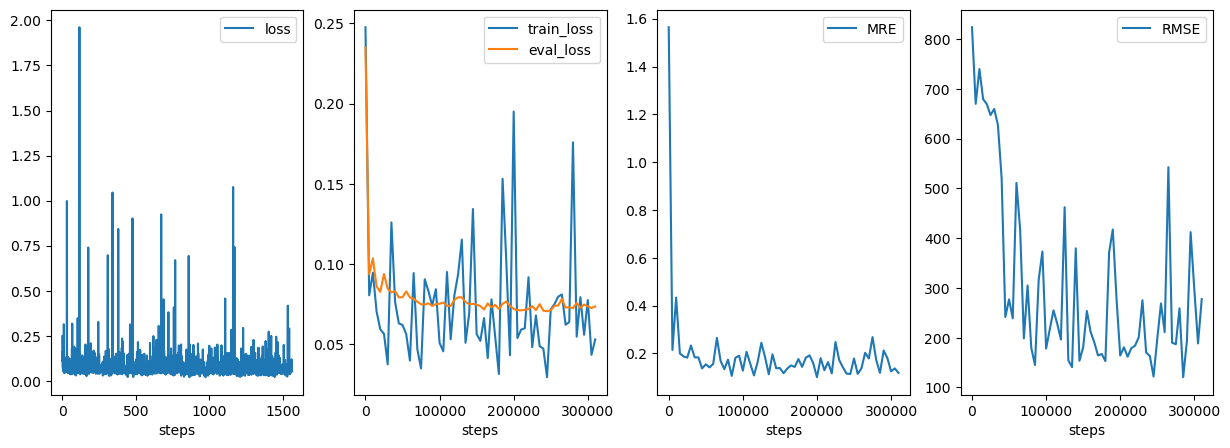

In [ ]:
single_train_loop(model_type, conf, preprocessed_train_ds, preprocessed_eval_ds, model, compute_evaluate_metrics, to_device)

In [ ]:
from executor import grid_search_loop
reload(executor)
# grid_search_loop(
#     model_type,
#     conf,
#     preprocessed_train_ds,
#     preprocessed_eval_ds,
#     compute_evaluate_metrics,
#     to_device,
#     init_model,
# )

<module 'executor' from '/root/guohao/repos/DLT-perf-model/notebooks/executor.py'>